<a href="https://colab.research.google.com/github/sayakpaul/E2E-Object-Detection-in-TFLite/blob/master/colab_training/Fruits_Detection_Data_Prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook shows how to prepare a object detection dataset in order to train it with the TFOD API in non-eager mode. It's a predecessor of the [training notebook](https://colab.research.google.com/github/sayakpaul/E2E-Object-Detection-in-TFLite/blob/master/colab_training/Training_MobileDet_Custom_Dataset.ipynb). 

## Data collection

Dataset homepage: https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection

In [ ]:
# Upload your Kaggle key file
# Details available here: https://www.kaggle.com/docs/api
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mbkinaci/fruit-images-for-object-detection
!unzip -qq fruit-images-for-object-detection.zip

 18% 5.00M/28.4M [00:00<00:01, 22.6MB/s]
100% 28.4M/28.4M [00:00<00:00, 81.6MB/s]


## Generate intermediate files

To be able to generate TFRecords from our fruits dataset we first generate a `.csv` file that would contain the following fields - 
- filename
- width
- height
- class
- xmin
- ymin
- xmax
- ymax

In [ ]:
!wget hhttps://gist.githubusercontent.com/sayakpaul/8db90aa7b0033df83c601e48658d97ac/raw/84c83b8b4470878bc7d7cd5d1366293a27e8e322/xml_to_csv.py

In [ ]:
!python xml_to_csv.py

Successfully converted xml to csv.
Successfully converted xml to csv.


In [ ]:
!head -5 /content/train_zip/train_labels.csv

filename,width,height,class,xmin,ymin,xmax,ymax
banana_42.jpg,1200,630,banana,125,133,772,497
banana_39.jpg,460,460,banana,33,213,459,427
mixed_4.jpg,640,857,orange,313,153,478,348
mixed_4.jpg,640,857,apple,127,148,320,371


In [ ]:
!head -5 /content/test_zip/test_labels.csv

filename,width,height,class,xmin,ymin,xmax,ymax
orange_79.jpg,425,425,orange,17,195,202,356
orange_79.jpg,425,425,orange,200,207,376,365
orange_79.jpg,425,425,orange,223,52,389,217
orange_79.jpg,425,425,orange,261,157,412,264


Now that we have `.csv` files we can do some basic exploratory data analysis (EDA) to better understand the dataset.

## Basic EDA

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os

In [ ]:
train_df = pd.read_csv("/content/train_zip/train_labels.csv")
test_df = pd.read_csv("/content/test_zip/test_labels.csv")

In [ ]:
train_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,banana_42.jpg,1200,630,banana,125,133,772,497
1,banana_39.jpg,460,460,banana,33,213,459,427
2,mixed_4.jpg,640,857,orange,313,153,478,348
3,mixed_4.jpg,640,857,apple,127,148,320,371
4,mixed_4.jpg,640,857,banana,73,366,618,619


In [ ]:
test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,orange_79.jpg,425,425,orange,17,195,202,356
1,orange_79.jpg,425,425,orange,200,207,376,365
2,orange_79.jpg,425,425,orange,223,52,389,217
3,orange_79.jpg,425,425,orange,261,157,412,264
4,orange_77.jpg,732,549,orange,1,123,130,299


In [ ]:
train_df["class"].value_counts()

banana    169
apple     156
orange    140
Name: class, dtype: int64

In [ ]:
test_df["class"].value_counts()

orange    42
banana    40
apple     35
Name: class, dtype: int64

In [ ]:
def show_images(df, is_train=True):
    if is_train:
        root = "/content/train_zip/train"
    else:
        root = "/content/test_zip/test"
    plt.figure(figsize=(15,15))
    for i in range(10):
        n = np.random.choice(df.shape[0], 1)
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(True)
        image = plt.imread(os.path.join(root, df["filename"][int(n)]))
        plt.imshow(image)
        label = df["class"][int(n)]
        plt.xlabel(label)
    plt.show()

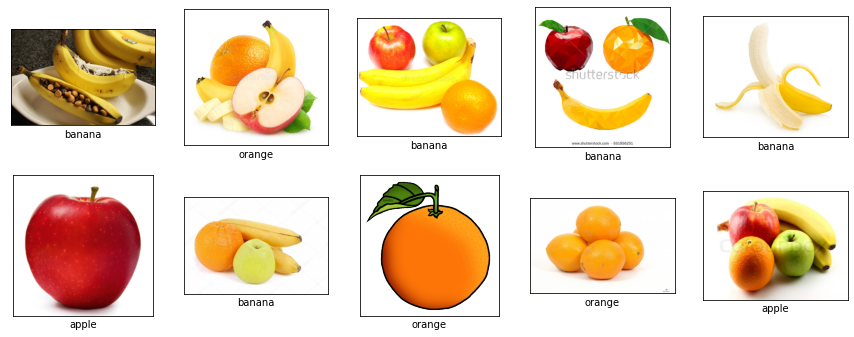

In [ ]:
show_images(train_df)

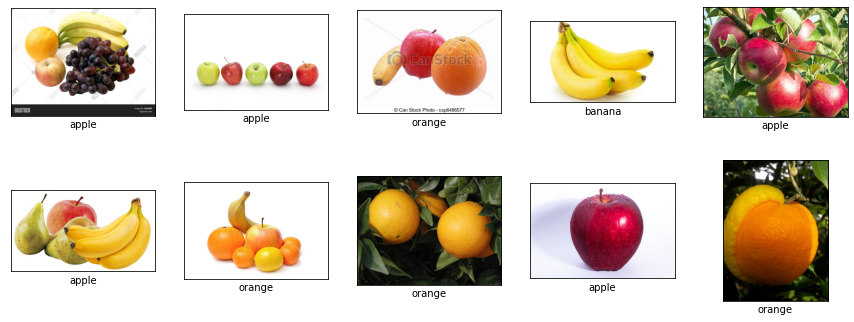

In [ ]:
show_images(test_df, is_train=False)

In [ ]:
def verify_annotations(df, is_train=True):
    if is_train:
        root = "/content/train_zip/train"
    else:
        root = "/content/test_zip/test"
    
    plt.figure(figsize=(12,12))
    for i in range(3):
        n = np.random.choice(df.shape[0], 1)
        plt.subplot(1,3,i+1)
        plt.xticks([])
        plt.yticks([])
        
        image = plt.imread(os.path.join(root, df["filename"][int(n)]))
        xmin, ymin = int(df["xmin"][int(n)]), int(df["ymin"][int(n)])
        xmax, ymax = int(df["xmax"][int(n)]), int(df["ymax"][int(n)])
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255,0,0), 3)
        plt.imshow(image)
    
    plt.show()

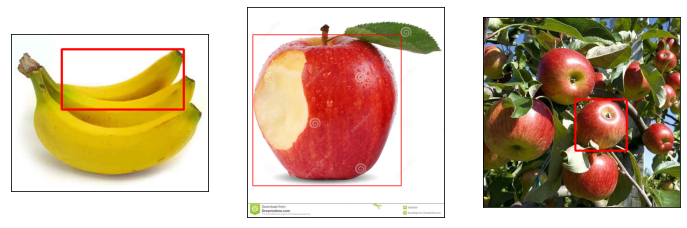

In [ ]:
verify_annotations(train_df, is_train=True)

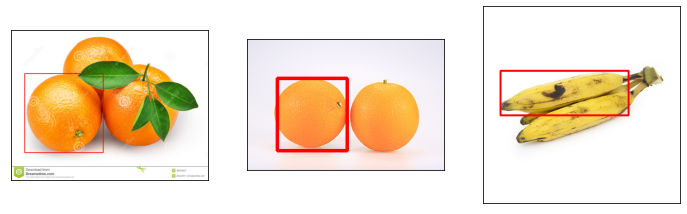

In [ ]:
verify_annotations(test_df, is_train=False)

## Generate TFRecords and `.pbtxt`

Explaining the steps of creating TFRecords is out of scope here. Please follow this Kaggle kernel that sheds some light on the process. 

The utility scripts that I used in the following cells were adapted from [this repository](https://github.com/anirbankonar123/CorrosionDetector). 

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf 
print(tf.__version__)

!git clone https://github.com/tensorflow/models.git

% cd models/research
!pip install --upgrade pip
# Compile protos.
!protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
!cp object_detection/packages/tf1/setup.py .
!python -m pip install --use-feature=2020-resolver .

In [ ]:
!wget https://gist.githubusercontent.com/sayakpaul/9a6fce48f346b40a20c7a91effa3eb2d/raw/92cbe5cf95d06a973171cf4a4d9cd226cc05e631/generate_tfrecord.py

In [ ]:
!python generate_tfrecord.py \
    --csv_input=/content/train_zip/train_labels.csv \
    --output_path=/content/train_zip/train.record



W0915 03:17:02.575953 140151683213184 module_wrapper.py:139] From generate_tfrecord.py:88: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0915 03:17:02.649518 140151683213184 module_wrapper.py:139] From generate_tfrecord.py:47: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/train_zip/train.record


Before the running the cell below please edit the `path` variable in the `main()` function of `generate_tfrecord.py`. `generate_tfrecord.py` should be located here - `/content/models/research`. 

In [ ]:
!python generate_tfrecord.py \
    --csv_input=/content/test_zip/test_labels.csv \
    --output_path=/content/test_zip/test.record



W0915 03:21:08.060053 140464756594560 module_wrapper.py:139] From generate_tfrecord.py:88: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0915 03:21:08.084097 140464756594560 module_wrapper.py:139] From generate_tfrecord.py:47: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

Successfully created the TFRecords: /content/test_zip/test.record


In [ ]:
!pwd
!ls -lh /content/test_zip/*.record
!ls -lh /content/train_zip/*.record

/content/models/research
-rw-r--r-- 1 root root 6.8M Sep 15 03:21 /content/test_zip/test.record
-rw-r--r-- 1 root root 23M Sep 15 03:17 /content/train_zip/train.record


Be sure to store these `.record` files to somewhere safe. Next, we need to generate a `.pbtxt` file that defines a mapping between our classes and integers. In the `generate_tfrecord.py` script, we used the following mapping - 

```python
def class_text_to_int(row_label):
    if row_label == 'orange':
        return 1
    elif row_label == 'banana':
        return 2
    elif row_label == 'apple':
        return 3
    else:
    	return None
```

In [ ]:
label_encodings = {
    "orange": 1,
    "banana": 2,
    "apple": 3
}

f = open("/content/label_map.pbtxt", "w")

for (k, v) in label_encodings.items():
    item = ("item {\n"
            "\tid: " + str(v) + "\n"
            "\tname: '" + k + "'\n"
            "}\n")
    f.write(item)

f.close()

!cat /content/label_map.pbtxt

item {
	id: 1
	name: 'orange'
}
item {
	id: 2
	name: 'banana'
}
item {
	id: 3
	name: 'apple'
}


Be sure to save this file as well. Next we will proceed toward training a custom detection model with what we have so far. Follow the steps in [this notebook](https://colab.research.google.com/github/sayakpaul/E2E-Object-Detection-in-TFLite/blob/master/colab_training/Training_MobileDet_Custom_Dataset.ipynb).